# Data Analysis
## People

In this notebook, we will see how leading personnels (e.g. cast, writer, director, etc.) influence the success of the film. Additionally we will see if the trend is different for domestic sales vs. worldwide.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#loading data
df = pd.read_csv('data/profit_data.csv', index_col = 0)
df.head(3)

,popularity,vote_count,id_x,adult,original_language,title,vote_average,overview,MPAA,year,...,start_year,runtime_minutes,genres,avg_rating_imdb,num_votes_imdb,actors,directors,producers,editors,writers
0,31.998,2653,189,False,en,sin city: a dame to kill for,6.3,Some of Sin City's most hard-boiled citizens c...,R,2014,...,2014,102.0,"Crime,Thriller",6.5,140666,"Josh Brolin,Mickey Rourke,Jessica Alba,Joseph ...","Frank Miller,Robert Rodriguez","Mark C. Manuel,Sergei Bespalov,Aaron Kaufman,S...",NaN,NaN
1,14.736,15131,1771,False,en,captain america: the first avenger,6.9,"During World War II, Steve Rogers is a sickly ...",PG-13,2011,...,2011,124.0,"Action,Adventure,Sci-Fi",6.9,668137,"Chris Evans,Samuel L. Jackson,Hugo Weaving,Hay...",Joe Johnston,Kevin Feige,NaN,"Jack Kirby,Christopher Markus,Stephen McFeely,..."
2,24.337,10020,1865,False,en,pirates of the caribbean: on stranger tides,6.5,Captain Jack Sparrow crosses paths with a woma...,PG-13,2011,...,2011,136.0,"Action,Adventure,Fantasy",6.6,447624,"Johnny Depp,Geoffrey Rush,Ian McShane,Penélope...",Rob Marshall,NaN,NaN,"Stuart Beattie,Ted Elliott,Terry Rossio,Tim Po..."


In [4]:
# Adding rev to cost ratios 
df['rev2bud_dom'] = df.domestic_gross/df.production_budget
df['rev2bud_int'] = df.worldwide_gross/df.production_budget

In [5]:
# add primary genre
df['primary_genre'] = df.genres.str.split(',', expand = True)[0]

In [6]:
# add top 4 main actors
actors = df.actors.str.split(',', expand = True)
df['cast_1'] = actors[0]
df['cast_2'] = actors[1]
df['cast_3'] = actors[2]
df['cast_4'] = actors[3]


In [7]:
# add the main director
directors = df.directors.str.split(',', expand = True)
df['main_director'] = directors[0]


In [8]:
# add the main writer
writers = df.writers.str.split(',', expand = True)
df['main_writer'] = writers[0]


#### Standardizing Popularity & Rating
Also we have 'popularity' measure from TMDB, and ratings from IMDB. We will standardize these scores to compare within the curret database. 


In [9]:
df['popularity_z'] = df.popularity.apply(lambda x: (x-df.popularity.mean())/(df.popularity.std()))
df['rating_z_IMDB'] = df.avg_rating_imdb.apply(lambda x: (x-df.avg_rating_imdb.mean())/(df.avg_rating_imdb.std()))


## Directors

### Prolific Directors

In [10]:
num_films_p_dirs = df.groupby('main_director').title.count().sort_values(ascending = False)

print("""Out of {} directors in our dataset, 
{} is the most prolific director with {} movies since 2010.""".format(len(num_films_p_dirs), num_films_p_dirs.index[0], num_films_p_dirs[0]))


Out of 745 directors in our dataset, 
Steven Spielberg is the most prolific director with 7 movies since 2010.


### Top 20 Grossing Directors (Worldwide)

In [11]:
dirdf = df[['title', 'worldwide_gross', 'rev2bud_int', 'rev2bud_dom', 'domestic_gross', 'rating_z_IMDB', 'popularity_z', 'production_budget', 'main_director']]


In [12]:
# Select top 20 directors with highest worldwide grossing
top20 = dirdf.groupby('main_director')['worldwide_gross', 'domestic_gross', 'production_budget']\
.sum().sort_values(by = 'worldwide_gross', ascending = False)[0:20]

In [13]:
# For these directors, get average IMDB rating and TMDB popularity scores. 
top20_names = top20.index
top20_subdf = dirdf[dirdf.main_director.isin(top20_names)].groupby('main_director')['rating_z_IMDB', 'popularity_z'].mean()
# Merge datasets
top20 = top20.join(top20_subdf)
top20 = top20.reset_index()

<Figure size 720x432 with 0 Axes>

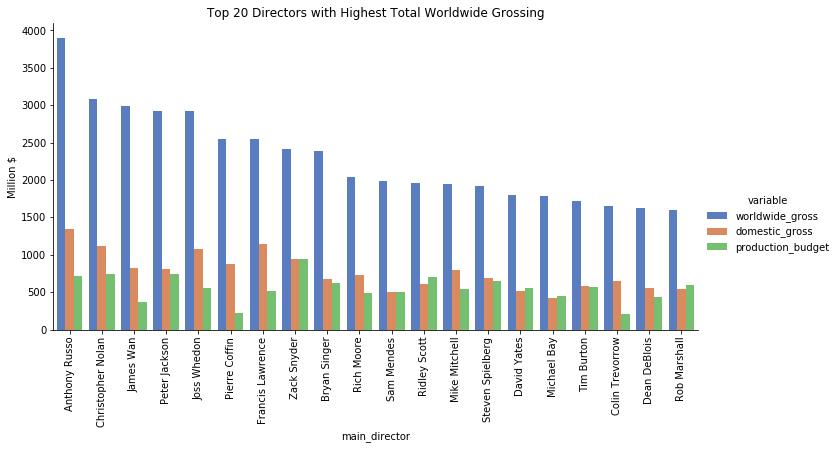

In [15]:
tmp = pd.melt(top20, id_vars=['main_director'], value_vars=['worldwide_gross', 'domestic_gross', 'production_budget'])

fig = plt.figure(figsize = (10,6))
g = sns.catplot(x="main_director", y="value", hue="variable", data=tmp, kind="bar", palette="muted", aspect = 2.)
g.set_xticklabels(rotation=90)
g.set(title = "Top 20 Directors with Highest Total Worldwide Grossing", ylabel = "Million $")
plt.show()


Do their IMDB rating and TMDB popularity measure up?

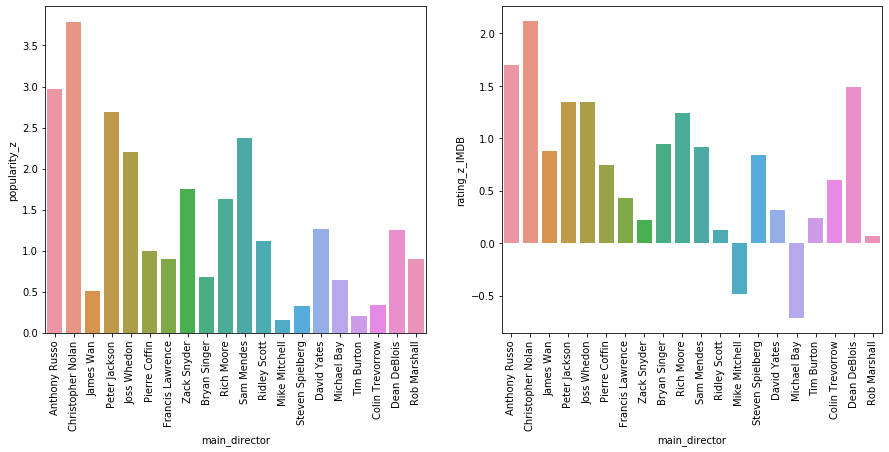

In [16]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(top20.main_director, top20.popularity_z, ax = ax1)
sns.barplot(top20.main_director, top20.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20.main_director, rotation=90)
ax2.set_xticklabels(labels = top20.main_director, rotation=90)


plt.show()

In [17]:
# Above plot might be a bit misleading as it doesn't include entire z-score distribution.
# In reality, they are more like this: 

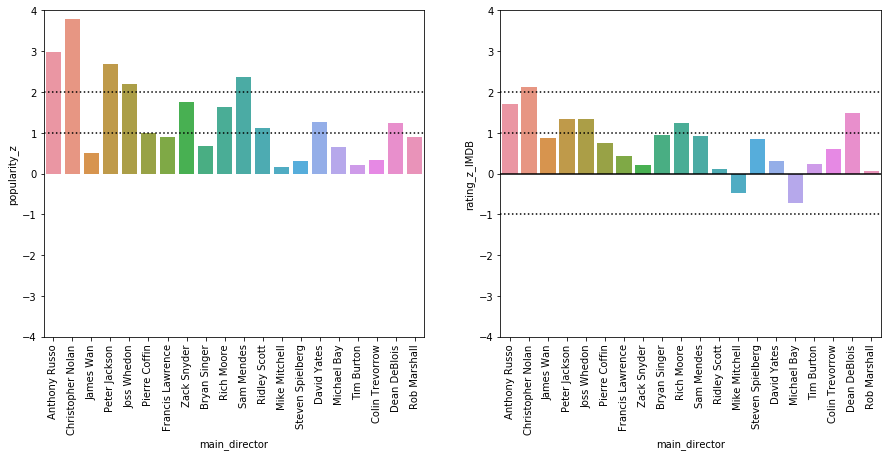

In [18]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.barplot(top20.main_director, top20.popularity_z, ax = ax1)
sns.barplot(top20.main_director, top20.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20.main_director, rotation=90)
ax2.set_xticklabels(labels = top20.main_director, rotation=90)
ax1.axhline(1, ls='dotted', c = 'black')
ax2.axhline(1, ls='dotted', c = 'black')
ax2.axhline(-1, ls='dotted', c = 'black')
ax2.axhline(0, ls='-', c = 'black')
ax2.axhline(2, ls='dotted', c = 'black')
ax1.axhline(2, ls='dotted', c = 'black')
ax1.set_ylim([-4, 4])
ax2.set_ylim([-4, 4])

plt.show()

These directors yielded highest cumulative grossing worldwide.  
But some might have been just more productive in the past decade.  
Let's look at the directors with highest average grossing per movie.

In [19]:
# Select top 20 directors with highest worldwide grossing
top20_mean = dirdf.groupby('main_director')['worldwide_gross', 'domestic_gross', 'production_budget', 'rating_z_IMDB', 'popularity_z']\
.mean().sort_values(by = 'worldwide_gross', ascending = False)[0:20]

<Figure size 1440x720 with 0 Axes>

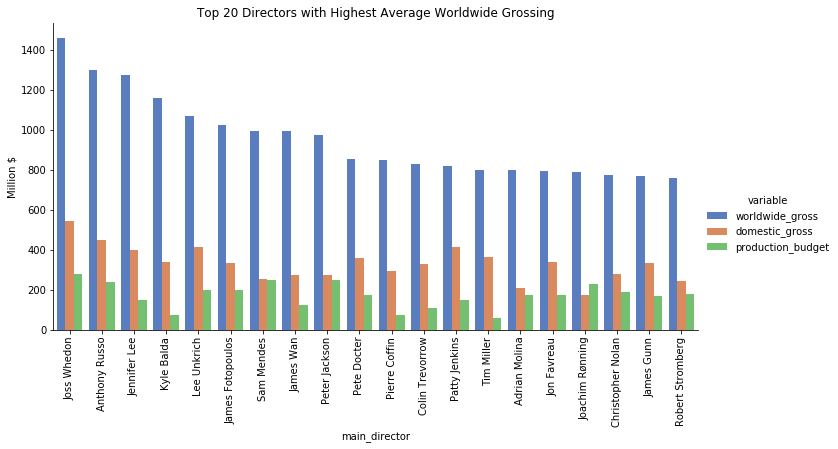

In [20]:
top20_mean = top20_mean.reset_index()
tmp = pd.melt(top20_mean, id_vars=['main_director'], value_vars=['worldwide_gross', 'domestic_gross', 'production_budget'])

fig = plt.figure(figsize = (20,10))
g = sns.catplot(x="main_director", y="value", hue="variable", data=tmp, kind="bar", palette="muted", aspect = 2)
g.set_xticklabels(rotation=90)
g.set(title = "Top 20 Directors with Highest Average Worldwide Grossing", ylabel = "Million $")
plt.show()


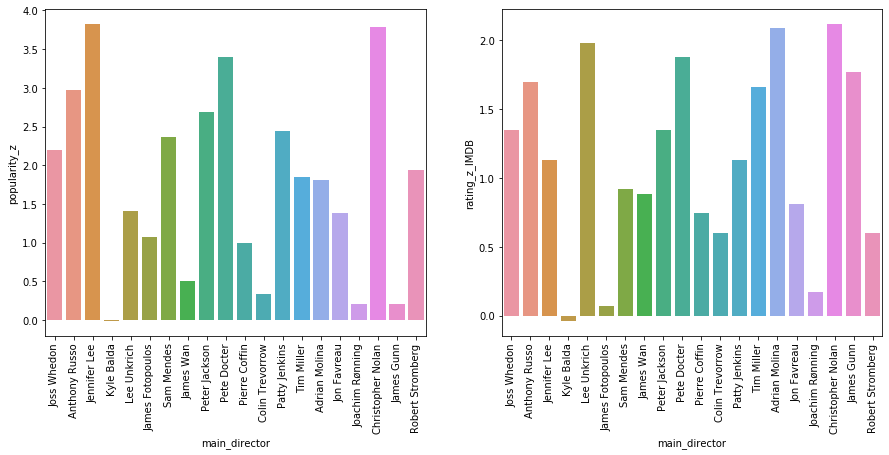

In [21]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(top20_mean.main_director, top20_mean.popularity_z, ax = ax1)
sns.barplot(top20_mean.main_director, top20_mean.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20_mean.main_director, rotation=90)
ax2.set_xticklabels(labels = top20_mean.main_director, rotation=90)


plt.show()

### Top 10 Highly Rated Directors

Which directors made the highest rated movies while keeping high rev to cost ratio?

#### Worldwide

In [22]:
dirdf[dirdf.rating_z_IMDB > 2].sort_values(by=['rev2bud_int'], ascending = False)

,title,worldwide_gross,rev2bud_int,rev2bud_dom,domestic_gross,rating_z_IMDB,popularity_z,production_budget,main_director
2355,dangal,294.65,31.015789,1.304211,12.39,2.194730,0.006483,9.5,Nitesh Tiwari
1529,whiplash,38.97,11.809091,3.966667,13.09,2.194730,2.104483,3.3,Damien Chazelle
1898,avengers: infinity war,2048.13,6.827100,2.262733,678.82,2.194730,7.258165,300.0,Anthony Russo
65,inception,835.52,5.222000,1.828625,292.58,2.513624,5.735627,160.0,Christopher Nolan
2331,coco,798.01,4.560057,1.198457,209.73,2.088432,1.811387,175.0,Adrian Molina
540,django unchained,449.95,4.499500,1.628100,162.81,2.088432,1.972565,100.0,Quentin Tarantino
1146,interstellar,666.38,4.038667,1.139515,188.02,2.301028,6.439837,165.0,Christopher Nolan
315,the dark knight rises,1084.44,3.943418,1.629600,448.14,2.088432,1.671667,275.0,Christopher Nolan


In [23]:
dirdf[dirdf.rating_z_IMDB > 2].sort_values(by=['worldwide_gross'], ascending = False)

,title,worldwide_gross,rev2bud_int,rev2bud_dom,domestic_gross,rating_z_IMDB,popularity_z,production_budget,main_director
1898,avengers: infinity war,2048.13,6.827100,2.262733,678.82,2.194730,7.258165,300.0,Anthony Russo
315,the dark knight rises,1084.44,3.943418,1.629600,448.14,2.088432,1.671667,275.0,Christopher Nolan
65,inception,835.52,5.222000,1.828625,292.58,2.513624,5.735627,160.0,Christopher Nolan
2331,coco,798.01,4.560057,1.198457,209.73,2.088432,1.811387,175.0,Adrian Molina
1146,interstellar,666.38,4.038667,1.139515,188.02,2.301028,6.439837,165.0,Christopher Nolan
540,django unchained,449.95,4.499500,1.628100,162.81,2.088432,1.972565,100.0,Quentin Tarantino
2355,dangal,294.65,31.015789,1.304211,12.39,2.194730,0.006483,9.5,Nitesh Tiwari
1529,whiplash,38.97,11.809091,3.966667,13.09,2.194730,2.104483,3.3,Damien Chazelle


#### Domestic

In [24]:
dirdf[dirdf.rating_z_IMDB > 2].sort_values(by=['rev2bud_dom'], ascending = False)

,title,worldwide_gross,rev2bud_int,rev2bud_dom,domestic_gross,rating_z_IMDB,popularity_z,production_budget,main_director
1529,whiplash,38.97,11.809091,3.966667,13.09,2.194730,2.104483,3.3,Damien Chazelle
1898,avengers: infinity war,2048.13,6.827100,2.262733,678.82,2.194730,7.258165,300.0,Anthony Russo
65,inception,835.52,5.222000,1.828625,292.58,2.513624,5.735627,160.0,Christopher Nolan
315,the dark knight rises,1084.44,3.943418,1.629600,448.14,2.088432,1.671667,275.0,Christopher Nolan
540,django unchained,449.95,4.499500,1.628100,162.81,2.088432,1.972565,100.0,Quentin Tarantino
2355,dangal,294.65,31.015789,1.304211,12.39,2.194730,0.006483,9.5,Nitesh Tiwari
2331,coco,798.01,4.560057,1.198457,209.73,2.088432,1.811387,175.0,Adrian Molina
1146,interstellar,666.38,4.038667,1.139515,188.02,2.301028,6.439837,165.0,Christopher Nolan


In [25]:
dirdf[dirdf.rating_z_IMDB > 2].sort_values(by=['domestic_gross'], ascending = False)

,title,worldwide_gross,rev2bud_int,rev2bud_dom,domestic_gross,rating_z_IMDB,popularity_z,production_budget,main_director
1898,avengers: infinity war,2048.13,6.827100,2.262733,678.82,2.194730,7.258165,300.0,Anthony Russo
315,the dark knight rises,1084.44,3.943418,1.629600,448.14,2.088432,1.671667,275.0,Christopher Nolan
65,inception,835.52,5.222000,1.828625,292.58,2.513624,5.735627,160.0,Christopher Nolan
2331,coco,798.01,4.560057,1.198457,209.73,2.088432,1.811387,175.0,Adrian Molina
1146,interstellar,666.38,4.038667,1.139515,188.02,2.301028,6.439837,165.0,Christopher Nolan
540,django unchained,449.95,4.499500,1.628100,162.81,2.088432,1.972565,100.0,Quentin Tarantino
1529,whiplash,38.97,11.809091,3.966667,13.09,2.194730,2.104483,3.3,Damien Chazelle
2355,dangal,294.65,31.015789,1.304211,12.39,2.194730,0.006483,9.5,Nitesh Tiwari


### Who's the most popular?
Based on average popularity and the ratings (in larger datasets)

In [106]:
tmp = dirdf.groupby('main_director')['rating_z_IMDB', 'popularity_z'].mean()
tmp[tmp.rating_z_IMDB > 1].sort_values(by = 'popularity_z', ascending = False)[0:15]
# Top 15 popular directors with high average IMDB ratings

,rating_z_IMDB,popularity_z
main_director,,
Jennifer Lee,1.131750,3.820751
Christopher Nolan,2.115007,3.786156
Don Hall,1.450644,3.546309
Pete Docter,1.875836,3.404028
Anthony Russo,1.698673,2.970725
Peter Jackson,1.344346,2.692056
Patty Jenkins,1.131750,2.444396
Joss Whedon,1.344346,2.200739
Tim Miller,1.663240,1.846500


## Writers

In [107]:
num_films_p_writers = df.groupby('main_writer').title.count().sort_values(ascending = False)

print("""Out of {} writers in our dataset, 
{} is the most prolific writer with {} movies since 2010.""".format(len(num_films_p_writers), num_films_p_writers.index[0], num_films_p_writers[0]))


Out of 763 writers in our dataset, 
Jack Kirby is the most prolific writer with 11 movies since 2010.


### Top 10 Highest Grossing Writers

In [129]:
writerdf = df[['title', 'worldwide_gross', 'rev2bud_int', 'rev2bud_dom', 'domestic_gross', 'rating_z_IMDB', 'popularity_z', 'production_budget', 'main_writer']]


In [130]:
# Select top 20 writers with highest worldwide grossing
top20 = writerdf.groupby('main_writer')['worldwide_gross', 'domestic_gross', 'production_budget']\
.sum().sort_values(by = 'worldwide_gross', ascending = False)[0:20]

In [131]:
# For these directors, get average IMDB rating and TMDB popularity scores. 
top20_names = top20.index
top20_subdf = writerdf[writerdf.main_writer.isin(top20_names)].groupby('main_writer')['rating_z_IMDB', 'popularity_z'].mean()
# Merge datasets
top20 = top20.join(top20_subdf)
top20 = top20.reset_index()

<Figure size 720x432 with 0 Axes>

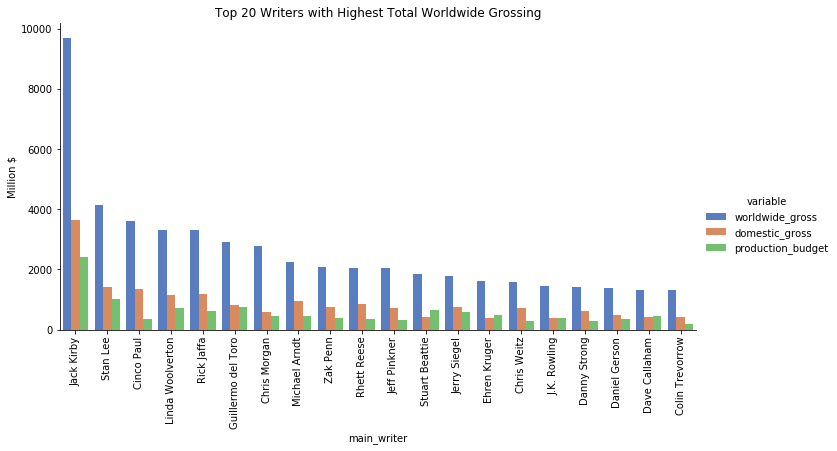

In [126]:
tmp = pd.melt(top20, id_vars=['main_writer'], value_vars=['worldwide_gross', 'domestic_gross', 'production_budget'])

fig = plt.figure(figsize = (10,6))
g = sns.catplot(x="main_writer", y="value", hue="variable", data=tmp, kind="bar", palette="muted", aspect = 2.)
g.set_xticklabels(rotation=90)
g.set(title = "Top 20 Writers with Highest Total Worldwide Grossing", ylabel = "Million $")
plt.show()


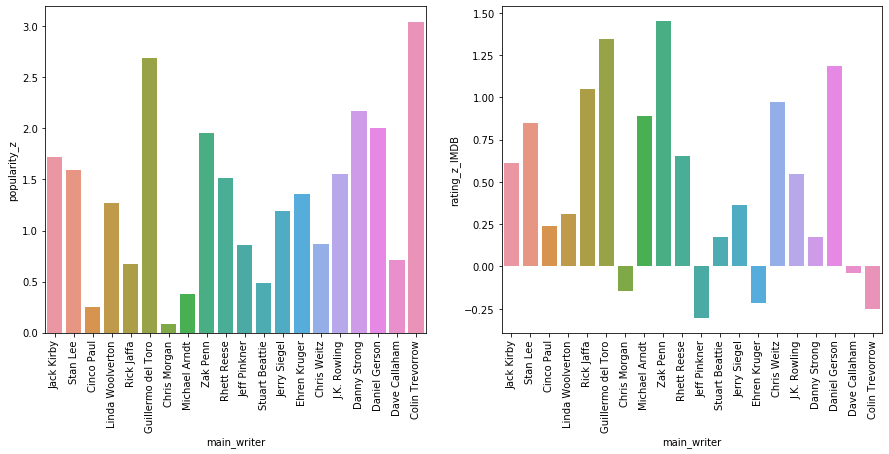

In [127]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot(top20.main_writer, top20.popularity_z, ax = ax1)
sns.barplot(top20.main_writer, top20.rating_z_IMDB, ax = ax2)
ax1.set_xticklabels(labels = top20.main_writer, rotation=90)
ax2.set_xticklabels(labels = top20.main_writer, rotation=90)

plt.show()

### Who's the most popular?

In [128]:
tmp = writerdf.groupby('main_writer')['rating_z_IMDB', 'popularity_z'].mean()
tmp[tmp.rating_z_IMDB > 1].sort_values(by = 'popularity_z', ascending = False)[0:15]

,rating_z_IMDB,popularity_z
main_writer,,
Jonathan Nolan,2.301028,6.439837
John August,1.025452,4.131769
Hans Christian Andersen,1.131750,3.820751
James Cameron,1.131750,3.484618
Simon Rich,1.875836,3.404028
Guillermo del Toro,1.344346,2.692056
Graham Moore,1.663240,2.580946
Phil Johnston,1.663240,2.371975
Drew Goddard,1.663240,2.273098


## Casts

### Top 10 Buzz Worthy Actors Internationally & Domestically 